Перед началом работы над проектом импортируем необходимые инструменты:

In [68]:
# Установка и обновление необходимых библиотек:
!pip install --upgrade scikit-learn -q
!pip install nltk -q
!pip install imblearn -q
!pip install spacy -q

In [69]:
# Импорт необходимых библиотек и модулей:
import pandas as pd
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from warnings import simplefilter
from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords

# Импорт инструмента подбора гиперпараметров:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# Импорт моделей МО:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

# Импорт функции метрики:
from sklearn.metrics import f1_score

# Импорт дамми-модели для проверки адекватности моделей:
from sklearn.dummy import DummyClassifier

In [3]:
# Дополнительные действия:

# Объявление констант:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Отключение предупреждений:
simplefilter(action='ignore')

# Загрузка стоп-слов:
nltk.download('stopwords')
stop_words = list(set(stopwords.words('english')))

# Добавление прогресс-баров:
tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Ознакомление

После импортирования необходимых инструментов считаем и сохраним полученный датасет. Далее проверим корректность считывания:

In [4]:
# Прочитаем и сохраним полученный датасет:
data = pd.read_csv('/datasets/toxic_comments.csv')

# Проверка считывания:
data.head(2)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0


Данные считаны не совсем корректно. Исправим это, указав значение параметру `index_col` функции `read_csv`.

In [5]:
# Пересчитывание датасета с добавленным аргументом:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

# Повторная проверка:
data.head(2)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


Теперь данные считаны корректно. Текст сырой и требует предварительной обработки перед передачей его алгоритмам МО, чем и займёмся позже.<br>А пока рассмотрим общую информацию о датасете:

In [6]:
# Вывод общей информации:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Пропусков не обнаружено. Названия основных столбцов и их формат данных в порядке. Убедимся в бинарности основного признака:

In [7]:
# Сделаем это циклом:
for column in data.columns:
    print(f'Кол-во уникальных значений столбца {column}: {data[column].nunique()}')

Кол-во уникальных значений столбца text: 159292
Кол-во уникальных значений столбца toxic: 2


Действиетельно, целевой признак является _бинарным_.<br>
Проверим наличие **явных** дубликатов. Объявим для этого функцию: 

In [8]:
# Функция для проверки наличия явных дубликатов:
def check_duplicates(df):
    print(f'Кол-во явных дубликатов в датасете: {df.duplicated().sum()}')

    if df.duplicated().sum() != 0:
        df.drop_duplicates(ignore_index=True, inplace=True)
        # Проверка:
        print(f'\nКол-во явных дубликатов после обработки: {df.duplicated().sum()}')
        print(f'Кол-во объектов в датасете: {df.shape[0]}')
    else:
        print('\nЯвных дубликатов не обнаружено.')

In [9]:
# Проверка наличия явных дубликатов:
check_duplicates(data)

Кол-во явных дубликатов в датасете: 0

Явных дубликатов не обнаружено.


Отлично, явных дубликатов не обнаружено.

### Вывод
На данном этапе мы:
- Корректно считали и сохранили данные, текст требует обработки;
- Убрали лишний неинформативный признак;
- Убедились в соответствии остальных данных в заявленной информации.

Можем переходить к следующему этапу.

## Подготовка данных

Для начала посмотрим, как обстоят дела с балансом классов. Напишем для этого функцию для наглядного графика:

In [10]:
# Создание функции для графика:
def show_balance(df, column='toxic', figsize=(8, 5), norm=True, name='общая выборка'):
    df.value_counts(normalize=norm).plot(
        kind='bar',
        grid=True,
        color='darkred',
        figsize=figsize
    )
    plt.title(f'Соотношение целевого признака, {name}', fontsize=13)
    plt.xlabel(f'Значение признака {column}', fontsize=12)
    plt.ylabel('Доля содержания в данных', fontsize=13)
    plt.xticks(rotation=0)

    return plt.show()

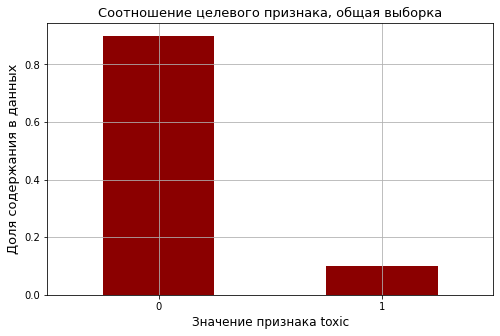

In [11]:
# Построение графика:
show_balance(data['toxic'])

Мы имеем дело с _дисбалансом классов_. Важнейшее значение целевого признака, которое предстоит определять (токсичность твита), представлено в датсете всего у **15%** объектов против **85%** "нетоксичных" объектов.

Таким образом, «нетоксичный» — это _мажорный_ класс, а «токсичный» — _минорный_.

Необходимо это учесть при разделении на выборки.<br>
Разделим данные на выборки и применим технику _undersampling_ к тренировочным данным, чтобы уравнять возможности модели обучиться определять оба класса.

### Разделение на выборки

Напишем функцию для разделения на выборки:

In [12]:
# Функция для разделения на выборки:
def get_samples(features, target,
                  stratify=None,
                  test_size=TEST_SIZE,
                  random_state=RANDOM_STATE):
            
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify)
    
    # Проверка:
    print('Размер тренировочной выборки: {:.0%}'.format(X_train.shape[0] / features.shape[0]))
    print('Размер тестовой выборки: {:.0%}'.format(X_test.shape[0] / target.shape[0]))
        
        
    return X_train, X_test, y_train, y_test

In [13]:
# Получение выборок:
X_train, X_test, y_train, y_test = get_samples(
    data['text'],
    data['toxic'],
    stratify=data['toxic']
)

# Вывод размерностей:
print(f'\nОбъектов в тренировочной: {X_train.shape[0]}')
print(f'Объектов в тестовой: {X_test.shape[0]}')

Размер тренировочной выборки: 75%
Размер тестовой выборки: 25%

Объектов в тренировочной: 119469
Объектов в тестовой: 39823


Получили тренировочные и тестовые выборки. Дополнительно можно проверить баланс классов в них, чтобы убедиться, что всё поровну:

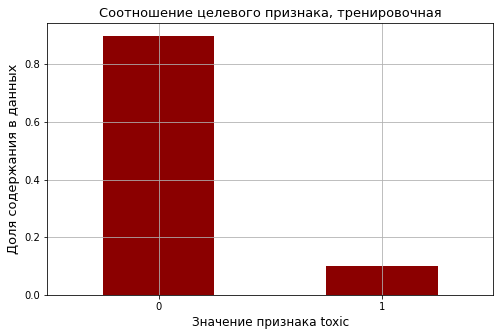

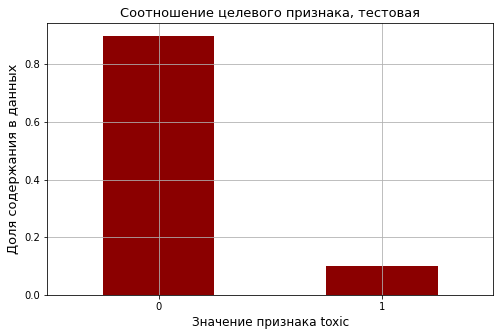

In [14]:
# Для удобства создадим списки и сделаем с помощью цикла:
sample_list = [y_train, y_test]
sample_names = ['тренировочная', 'тестовая']

for sample, name in zip(sample_list, sample_names):
    show_balance(sample, name=name)

Таким образом, мы разделили данные на выборки, сохранив пропорции значений целевого признака в каждой из них.

### Обработка текста

Предобработаем текст, чтобы нашим моделям было возможно с ним работать. Лемматизируем все твиты из нашего датасета, чтобы алгоритмы могли далее с ними работать. Для этого пригодится пару функций:

In [15]:
# Создание функции для очистки текста от лишних символов:
def clear_text(text):
    text_with_spaces = re.sub(r'[^a-zA-Z]', ' ', text)
    handling_spaces = text_with_spaces.split()
    cleared_text = ' '.join(handling_spaces).lower()
    
    # Удаление стоп-слов:
    filtered_words = [word for word in cleared_text.split() if word not in stop_words]
    cleared_text = ' '.join(filtered_words)
    
    return cleared_text

In [16]:
# Загрузка языковой модели:
nlp = spacy.load('en_core_web_sm')

# Создание функции для лемматизации текста:
def lemmatize_text(text):
    doc = nlp(text)
    lemmas_list = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmas_list)
    return lemmatized_text

Сделаем проверку объявленных функций:

In [17]:
# Проверка:
sentence = 'I am running in the park'

print('Исходный текст:', sentence)
print('Лемматизированный:', lemmatize_text(sentence))
print('Очищенный текст:', clear_text(sentence))
print('Лемм. + очищ.:', lemmatize_text(clear_text(sentence)))

Исходный текст: I am running in the park
Лемматизированный: I be run in the park
Очищенный текст: running park
Лемм. + очищ.: run park


Для начала очистим тексты от лишнего:

In [18]:
# Очистка текстов от лишнего:
X_train = X_train.progress_apply(clear_text)
X_test = X_test.progress_apply(clear_text)

# Проверка:
print(X_train.sample(1).values.tolist())
print()
print(X_test.sample(1).values.tolist())

  0%|          | 0/119469 [00:00<?, ?it/s]

  0%|          | 0/39823 [00:00<?, ?it/s]

['hey daniel seems large problem moment got yesterday willage pump question page queries fixed dummy edit clearing cache didnt work time odd errant tmorton talk review']

['preceding unsigned comment added appreciate personal attacks never less disagree conclusion related names mention fact unable find sort software otherwise related technology named peru seems fairly obvious java apple link respectively land mass fruit people would immediately relate words names sure jean auguste dominique ingres famous artist right hardly comparable artists like picasso da vinci goya etc achieved general recognition also outside art circles look artists like andy goldsworthy sebasti salgado ansel adams notice goldsworthy adams simply goes disambiguation page salgado article obscure brazilian village ingres artist generally well known person artist would agreed separate interest areas equal claim article namespace considering ingres rdbms actually named ingres ingres artist part artists name think mak

Приступим к лемматизации текста:

In [19]:
# Лемматизация текстов:
X_train = X_train.progress_apply(lemmatize_text)
X_test = X_test.progress_apply(lemmatize_text)

  0%|          | 0/119469 [00:00<?, ?it/s]

  0%|          | 0/39823 [00:00<?, ?it/s]

Проверим какой-нибудь текст:

In [20]:
# Проверка:
print(X_train.sample(1).values.tolist())

['note thank']


Сработало. Первоначальные варианты текстов нам больше не понадобятся.

Стоит проверить наличие явных дубликатов в тренировочной выборке после лемматизации, т.к. мы значительно упростили тексты.

In [22]:
# Временно соберём выборку обратно:
train_data = pd.concat([X_train, y_train], axis=1)

# Проверка наличия явных дубликатов:
check_duplicates(train_data)

# Разберём обратно:
X_train = pd.DataFrame(train_data['text'])
y_train = train_data['toxic']

# Удалим за ненадобностью:
del train_data

Кол-во явных дубликатов в датасете: 1255

Кол-во явных дубликатов после обработки: 0
Кол-во объектов в датасете: 118214


Теперь данные для обучения стали ещё лучше.

### Расчёт TF-IDF

Однако, подготовка данных на этом не оканчивается. Необходимо перевести тексты из датасета в векторный вид для того, чтобы алгоритмы могли с ними работать. Сделаем это с помощью величины _TF-IDF_. 

Напишем функцию, с помощью которой рассчитаем для слов в в наших выборках эти значения.

In [23]:
# Создание экземляра класса с передачей ему загруженных ранее стоп-слов:
vect = TfidfVectorizer(stop_words=stop_words)

# Функция для получения TF_IDF матриц:
def get_tf_idf(texts, vectorizer, train=True):
    corpus = texts.values
    
    if train == True:
        tf_idf = vectorizer.fit_transform(corpus)
               
    else:
        tf_idf = vectorizer.transform(corpus)
        
    return tf_idf

Получим матрицы с расчитанными значениями для слов из выборок:

In [24]:
# Получение тренировочной разряженной матрицы: 
tf_idf_train = get_tf_idf(
    X_train['text'],
    vect
)

# Расчёт тестовой матрицы:
tf_idf_test = get_tf_idf(
    X_test,
    vect,
    train=False
)

# Вывод размерностей:
print(f'Размерность тренировочной sparse-матрицы {tf_idf_train.shape}')
print(f'Размерность тестовой sparse-матрицы {tf_idf_test.shape}')

Размерность тренировочной sparse-матрицы (118214, 129321)
Размерность тестовой sparse-матрицы (39823, 129321)


### Вывод

На данном этапе мы:

- Получили выборки для обучения моделей и их проверки;
- Очистили и лемматизировали твиты;
- Убрали появившиеся дубликаты;
- Рассчитали показатели TF-IDF в их словах и получили результаты в виде матриц;


Можем переходить к следующему этапу.

## Обучение моделей

Опробуем несколько моделей МО: простую **LogisticRegression**, **PassiveAggressiveClassifier** и **CatboostClassifier**.

Для оценки качества моделей будем применять метрику **`F1`**. Согласно требованию заказчика, значение метрики F1 должно быть меньше `0.75`.

Для решения задачи будем использовать _RandomizedSearchCV_, с его помощью будем подбирать наиболее оптимальные гиперпараметры для моделей, чтобы получать наиболее точные предсказания.

### LogisticRegression

Начнём с модели лог. регрессии. Стоит передать при инициализации модели аргумент `class_weight`=**`'balanced'`**, чтобы модель автоматически рассчитала веса на основе частоты классов в наших данных. Затем подберём наиболее удачный набор параметров с помощью инструмента RandomizedSearchCV:

In [25]:
# Инициализация модели:
log_model = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Определим диапазоны параметров модели для поиска:
log_params = {
    'C': [1, 2, 3],
}

Передадим модель и значения коэффициента регуляризации _RandomizedSearchCV_.

In [26]:
# Инициализация инструмента подбора:
rs_log = RandomizedSearchCV(
    log_model,
    log_params,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    n_iter=3,
    random_state=RANDOM_STATE,
    verbose=2
)

# Запуск инструмента подбора:
rs_log.fit(tf_idf_train, y_train)
log_f1 = rs_log.best_score_

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs_log.best_params_)
print('\n\nМетрика F1 лучшей модели на кросс-валидации:',
      log_f1.round(3))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................................C=1; total time=  10.8s
[CV] END ................................................C=1; total time=  17.3s
[CV] END ................................................C=1; total time=  12.6s
[CV] END ................................................C=1; total time=  20.5s
[CV] END ................................................C=1; total time=  10.0s
[CV] END ................................................C=2; total time=  16.7s
[CV] END ................................................C=2; total time=  24.8s
[CV] END ................................................C=2; total time=  17.7s
[CV] END ................................................C=2; total time=  20.6s
[CV] END ................................................C=2; total time=  14.8s
[CV] END ................................................C=3; total time=  16.2s
[CV] END ........................................

Таким образом, лучшей оказалась модель с коэффициентом регуляризации `3`.

Для большей уверенности проверим её на адекватность. Сделаем это с помощью функции:

In [27]:
# Функция для проверки модели:
def check_model(metric, features_train=tf_idf_train,
                target_train=y_train, first_time=False, f1_dummy=None):
    
    if first_time == True:
        
        # Инициализация дамми-модели:
        dummy_clf = DummyClassifier(strategy='constant', constant=1)
        
        # Проведение кросс-валидации дамми-модели:
        dummy_cv = cross_val_score(
            dummy_clf,
            features_train,
            target_train,
            scoring='f1',
            n_jobs=-1
        ).mean()
        
        # Получение метрики:
        print('Метрика F1 дамми-модели на кросс-валидации:',
          round(dummy_cv, 3), '=>')
    
        # Презентация результатов:
        if dummy_cv < metric:
            print('=> Модель прошла проверку на адекватность.')
        else:
            print('=> Модель НЕ прошла проверку на адекватность.')
        
        return dummy_cv
            
    else:
        f1_dummy = f1_dummy
        if f1_dummy < metric:
            print('Модель прошла проверку на адекватность.')
        else:
            print('Модель НЕ прошла проверку на адекватность.')

Применим функцию и сохраним результат:

In [28]:
# Проверка на адекватность модели:
f1_dummy = check_model(log_f1, first_time=True)

Метрика F1 дамми-модели на кросс-валидации: 0.185 =>
=> Модель прошла проверку на адекватность.


Таким образом, для следующих моделей мы сможем просто сравнивать их метрики с сохранённой метрикой дамми-модели.

### CatboostClassifier

Рассмотрим модель, основанную на бустинге. Проведём для неё поиск гиперпараметров:

In [96]:
# Инициализация модели:
catboost_model = CatBoostClassifier(
    iterations=10,
    auto_class_weights='Balanced',
    random_state=RANDOM_STATE,
    silent=True
)

# Задаём области поиска гиперпараметров:
cat_params = {
    'learning_rate': [1, 0.8]
}

In [97]:
# Инициализация инструмента подбора:
rs_cat = RandomizedSearchCV(
    catboost_model,
    cat_params,
    scoring='f1',
    n_jobs=-1,
    cv=3,
    n_iter=3,
    random_state=RANDOM_STATE,
    verbose=2
)

# Запуск инструмента подбора:
rs_cat.fit(tf_idf_train, y_train)
cat_f1 = rs_cat.best_score_

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs_cat.best_params_)
print('\n\nМетрика F1 лучшей модели на кросс-валидации:',
      cat_f1.round(3))

Fitting 3 folds for each of 2 candidates, totalling 6 fits


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

[CV] END ....................................learning_rate=1; total time=  39.7s
[CV] END ....................................learning_rate=1; total time=  39.5s
[CV] END ....................................learning_rate=1; total time=  38.4s
[CV] END ..................................learning_rate=0.8; total time=  39.1s
[CV] END ..................................learning_rate=0.8; total time=  39.0s
[CV] END ..................................learning_rate=0.8; total time=  38.7s
Лучшие гиперпараметры модели:

 {'learning_rate': 0.8}


Метрика F1 лучшей модели на кросс-валидации: 0.662


К сожалению, результат кросс-валидации удручает и не справляется с задачей. Думаю, можно было добавить ещё параметров для поиска, но это заняло бы много времени. Остановимся на этом результате.

In [36]:
# Проверка на адекватность:
check_model(cat_f1, f1_dummy=f1_dummy)

Модель прошла проверку на адекватность.


### PassiveAggressiveClassifier

Рассмотрим эту модель МО и также укажем ей `class_weight`=**`'balanced'`**.

In [37]:
# Инициализация модели:
pa_model = PassiveAggressiveClassifier(
    class_weight='balanced',
    early_stopping=True,
    n_jobs=1,
    random_state=RANDOM_STATE
)

# Задаём области поиска гиперпараметров:
pa_params = {
    'C': [1, 0.9, 0.8],
}

In [38]:
# Инициализация инструмента подбора:
rs_pa = RandomizedSearchCV(
    pa_model,
    pa_params,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    n_iter=3,
    random_state=RANDOM_STATE,
    verbose=2
)

# Запуск инструмента подбора:
rs_pa.fit(tf_idf_train, y_train)
pa_f1 = rs_pa.best_score_

# Вывод результатов:
print('Лучшие гиперпараметры модели:\n\n', rs_pa.best_params_)
print('\n\nМетрика F1 лучшей модели на кросс-валидации:',
      pa_f1.round(3))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................................C=1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.4s
[CV] END ................................................C=1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.6s
[CV] END ................................................C=1; total time=   0.5s
[CV] END ..............................................C=0.9; total time=   0.5s
[CV] END ..............................................C=0.9; total time=   0.5s
[CV] END ..............................................C=0.9; total time=   0.7s
[CV] END ..............................................C=0.9; total time=   0.6s
[CV] END ..............................................C=0.9; total time=   0.6s
[CV] END ..............................................C=0.8; total time=   0.5s
[CV] END ........................................

Неплохой результат! Но с задачей она справляется недостаточно хорошо и тоже не дотягивает до лог. рега.

In [40]:
# Проверка на адекватность:
check_model(pa_f1, f1_dummy=f1_dummy)

Модель прошла проверку на адекватность.


### Результаты обучения

Рассмотрим общий результат по валидационным выборкам по всем моделям, что мы обучили. Так мы сможем нагляднее избрать лучшую для вывода в прод.

In [41]:
# Построение результата в виде таблицы:
results_data = {
    'Модель': ['LogisticRegression', 'CatBoost', 'PassiveAggressive'],
    'f1_valid': [log_f1, cat_f1, pa_f1]
}

results = pd.DataFrame(results_data)
results.sort_values('f1_valid', ascending=False).round(3)

,Модель,f1_valid
0,LogisticRegression,0.759
2,PassiveAggressive,0.736
1,CatBoost,0.662


Таким образом, все модели справились с поставленной задачей. Лучше всех на валидационных данных справилась модель **логистической регрессии**. Опробуем её на тестовых данных.

### Вывод

На данном этапе мы:
- Обучили _3 модели МО_: **LogisticRegression**, **CatBoostClassifier** и **PassiveAggressiveClassifier**.
- Справилась с задачей при кросс-валидации только **LogisticRegression**.
- Наилучшим образом себя показала модель **LogisticRegresson** _с коэфф-том регуляризации 3_, её мы и будем тестировать на следующем этапе. 
<br>


Переходим к следующему этапу.

## «Вывод в прод»

Самое время проверить полученную лучшую модель на тестовых данных, которые не участвовали до этого нигде в процессе.

In [43]:
# Получение предсказаний на тестовой выборке:
predictions = rs_log.best_estimator_.predict(tf_idf_test)

    # Расчёт метрики:
f1_result = f1_score(y_test, predictions)

    # Вывод результата:
print('Метрика F1 лучшей модели на тестовой выборке:',
    round(f1_result, 3))

Метрика F1 лучшей модели на тестовой выборке: 0.765


Отлично, модель успешно справляется с тестовыми данными, метрика даже повысилась.

### Важные признаки

Теперь, когда модель логистической регрессии справилась с тестовыми данными, интересно узнать, на какие слова она опирается сильнее всего, когда делает свои прогнозы. Построим наглядный график, где покажем значимость топ-5 слов.

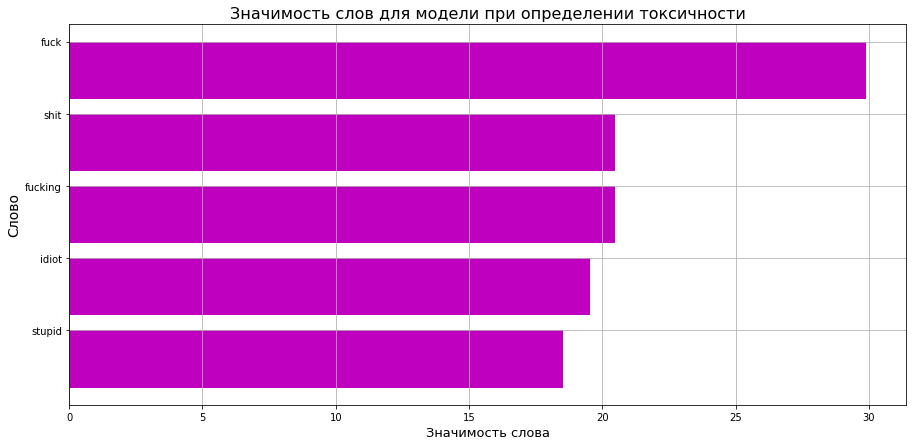

In [67]:
# Получим значения коэффициентов:
coefficients = rs_log.best_estimator_.coef_[0]

# Получим имена признаков (слова):
feature_names = vect.get_feature_names_out()

# Оформляем результаты для топ-5 слов:
imp_data = {'word': feature_names, 'importance': coefficients}
importances = pd.DataFrame(imp_data)
importances_top5 = importances.sort_values(
    by='importance', ascending=False).head()

# Построение графика:
plt.figure(figsize=(15, 7))
plt.barh(importances_top5['word'], importances_top5['importance'],
         color='m', align='edge')
plt.grid(True)
plt.title('Значимость слов для модели при определении токсичности', fontsize=16)
plt.ylabel('Слово', fontsize=14)
plt.xlabel('Значимость слова', fontsize=13)
plt.gca().invert_yaxis()

plt.show()

### Вывод

На этом этапе мы проверили лучшую модель на тестовых данных. Получили от неё предсказания и рассчитали значение метрики **F1**, она выросла на тесте и её значение составило **`0.765`**.<br> Затем мы отобрали коэффициенты модели и оформили в виде графика.<br>

Таким образом, мы обнаруживаем, что именно эти обсценные слова на оси Y на графике оказывают наибольшее влияние на определение токсичности текста.


## Общий вывод

Перед нами стояла NLP-задача **построения модели МО для определения токсичности текста**, то есть задача _бинарной классификации_.


Для решения этой задачи были проделаны следующие этапы:

1. **Исходные данные представляли собой датасет с исходными текстами и метками к ним**. С ними было проведено ознакомление и проверка соответствия их описанию.
    
    - Убрали лишний признак;
    - Выявили сильный дисбаланс классов;
    - Проверили данные на явные дубликаты;


2. **В процессе предобработки данных на этапе лемматизации текста были обнаружены новые явные дубликаты**. От них мы избавились, тем самым улучшив данные для обучения.
    - В итоге мы получили рахряженные матрицы с рассчитанными значениями TF-ITF для каждого из всех слов в текстах, не являющихся стоп-словом (стоп-слова мы исключили).


5. Далее **мы обучили и протестировали три модели машинного обучения**, одна из которых основана на бустинге. Все модели, прошли проверку на адекватность и далеко не все показали хорошие результаты. Результаты нам пригодились, чтобы выбрать лучшую модель.


6. **Лучшей моделью** для решения нашей задачи оказалась **_LogisticRegression_** со значением метрики F1 в **0.759** _на кросс-валидации_ и **0.765** на проде (тестовых данных). Впоследствии мы выяснили, какие обсценные слова больше всего оказывают влияние на предсказания:<br>
    - **`fuck`** — слово с наивысшим коэффициентом, влияющим на определение лучшей моделью токсичности. За ним с сильным отставанием идут слова `shit`, `fucking`, `idiot` и `stupid`.